<a href="https://colab.research.google.com/github/erfan-sams/pretrained-fake-news-detection/blob/main/Fake_News_classification_with_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import and install dependencies

You need to use your kaggle API key to download this dataset
(upload the “kaggle.json” file that you just downloaded from Kaggle).

I used this [A tutorial on multiclass text classification using Hugging Face transformers.](https://towardsdatascience.com/news-category-classification-fine-tuning-roberta-on-tpus-with-tensorflow-f057c37b093)


I had no experience with NLP transformers before this project.

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download clmentbisaillon/fake-and-real-news-dataset/

 76% 31.0M/41.0M [00:00<00:00, 40.5MB/s]
100% 41.0M/41.0M [00:00<00:00, 50.7MB/s]


In [ ]:
!unzip fake-and-real-news-dataset.zip

!pip install transformers
!apt install git-lfs
!git lfs install
!pip install huggingface_hub

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                
     |████████████████████████████████| 3.8 MB 4.5 MB/s 
     |████████████████████████████████| 6.6 MB 27.3 MB/s 
     |████████████████████████████████| 895 kB 30.3 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 67 kB 3.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log


In [ ]:
import tensorflow as tf
import numpy as np
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers.keras_callbacks import PushToHubCallback

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

##Initialize TPU Strategy

In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

batch_size=32 * tpu_strategy.num_replicas_in_sync
print('Batch size:', batch_size)
AUTOTUNE = tf.data.experimental.AUTOTUNE

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.50.127.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.50.127.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Batch size: 256


##Visualize and preprocess data

Let's load the data. We will combine the title and the description into a single string we will use as input for the model. 

In [ ]:
true = pd.read_csv("./Fake.csv")
false = pd.read_csv("./True.csv")

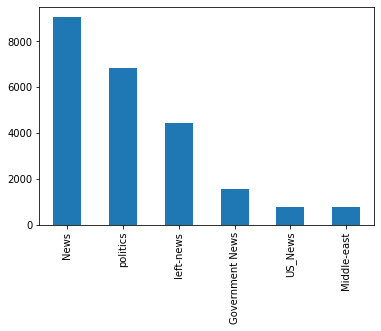

In [ ]:
true.subject.value_counts().plot(kind="bar")

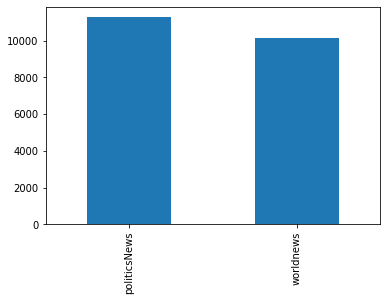

In [ ]:
false.subject.value_counts().plot(kind="bar")

The subjects are not the same! also, they are few so we don't use them for training.

In [ ]:
true["category"] = 1
false["category"] = 0

In [ ]:
df = pd.concat([true, false],ignore_index=True)

In [ ]:
df

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


As you can see in the fake news dataset there are so many rows with similar text and titles.
but we don't want to remove them because we use text + title for my classification. And finnaly remove duplicate texts.

In [ ]:
df.groupby('category').describe()

title                                                            \
          count unique                                                top   
category                                                                    
0         21417  20826  Factbox: Trump fills top jobs for his administ...   
1         23481  17903  MEDIA IGNORES Time That Bill Clinton FIRED His...   

                text         \
         freq  count unique   
category                      
0          14  21417  21192   
1           6  23481  17455   

                                                                 subject  \
                                                        top freq   count   
category                                                                   
0         (Reuters) - Highlights for U.S. President Dona...    8   21417   
1                                                            626   23481   

                                       date                                  
         unique           top   freq  count unique                 top freq  
category                                                                     
0             2  politicsNews  11272  21417    716  December 20, 2017   182  
1             6          News   9050  23481   1681        May 10, 2017   46

In [ ]:
sn.countplot(df.category)

We concatenate text with titles.

In [ ]:
df['text'] = df['text'] + ' ' + df['title']
df = df.drop(["subject", "date"], axis = 1)

print('Number of news',df.shape[0])

# Remove dulpicate elements
df = df.drop_duplicates(subset='text')
df['text_length'] = df.text.str.len()

print('After removing dulicate texts, number of news:',df.shape[0])

In [ ]:
df.groupby('category').describe()

In [ ]:
sn.countplot(df.category)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.category, test_size = 0.1, random_state = 42)
train_texts = x_train.tolist() 
train_labels = y_train.tolist()
indices = tf.one_hot(train_labels, 2)

test_texts = x_test.tolist()
test_labels = y_test
del x_train , x_test, true, false, y_train, y_test

# Training

Let's now prepare the dataset to feed it to the model. We need to transform the category labels into indices and to tokenize the input text. The AutoTokenizer class of Huggingface allows to tokenize the dataset using the tokenizer used in the pretraining of the model. We will use the "roberta-base" model. 

In [ ]:
n_categories = 2
n_elements = df.shape[0]

tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
inputs = tokenizer(train_texts, padding=True, truncation=True, return_tensors='tf') #Tokenized text
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), indices)) #Create a tensorflow dataset
#train valid test split, we use 10% of the data for validation and 10% for test 

val_data_size=int(0.1*n_elements)
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Let's visualize how the tokenizer splits the text into (sub)words and how text gets tokenized.

In [ ]:
tokens=tokenizer(train_texts[:2], padding=True, truncation=True)['input_ids']
for i in range(2):
  print('Input:',train_texts[i])
  print('Subword tokenization:',tokenizer.tokenize(train_texts[i]))
  print('Indices:', tokens[i])
  print('\n','----------------------------------------------------------------------------','\n')


Input: WASHINGTON (Reuters) - Jared Kushner, adviser and son-in-law to President Donald Trump, was questioned for nearly three hours on Tuesday by members of a House of Representatives intelligence panel investigating possible ties between Russia and the Trump campaign. “I found him to be straightforward and forthcoming. He wanted to answer every question that we had,” Republican Representative Mike Conaway said. Democratic Representative Adam Schiff said Kushner and his lawyer were receptive to coming back for additional questioning. “It was a very productive session,” Schiff said.  Kushner interviewed by House intelligence panel
Subword tokenization: ['WASHINGTON', 'Ġ(', 'Reuters', ')', 'Ġ-', 'ĠJared', 'ĠKushner', ',', 'Ġadviser', 'Ġand', 'Ġson', '-', 'in', '-', 'law', 'Ġto', 'ĠPresident', 'ĠDonald', 'ĠTrump', ',', 'Ġwas', 'Ġquestioned', 'Ġfor', 'Ġnearly', 'Ġthree', 'Ġhours', 'Ġon', 'ĠTuesday', 'Ġby', 'Ġmembers', 'Ġof', 'Ġa', 'ĠHouse', 'Ġof', 'ĠRepresentatives', 'Ġintelligence', 'Ġpa

We see that the character 'Ġ' is used to indicate the start of a new word in the text, while the other parts of the words that get split don't contain it. For example 'reevaluate' gets split into 'Ġre' and 'evaluate'. We further notice that the tokenize uses the index 0 to indicate the beginning of the text and 2 to indicate the ending. Index 1 is reserved for padding. 

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
140/140 [==============================] - 230s 972ms/step - loss: 0.1459 - binary_accuracy: 0.9260 - auc: 0.9909 - val_loss: 0.0088 - val_binary_accuracy: 1.0000 - val_auc: 1.0000
Epoch 2/5
140/140 [==============================] - 127s 907ms/step - loss: 0.0077 - binary_accuracy: 0.9998 - auc: 0.9999 - val_loss: 0.0035 - val_binary_accuracy: 1.0000 - val_auc: 1.0000
Epoch 3/5
140/140 [==============================] - 127s 907ms/step - loss: 0.0038 - binary_accuracy: 0.9999 - auc: 0.9999 - val_loss: 0.0020 - val_binary_accuracy: 1.0000 - val_auc: 1.0000
Epoch 4/5
140/140 [==============================] - 127s 908ms/step - loss: 0.0021 - binary_accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0013 - val_binary_accuracy: 1.0000 - val_auc: 1.0000
Epoch 5/5
140/140 [==============================] - 127s 908ms/step - loss: 0.0015 - binary_accuracy: 1.0000 - auc: 1.0000 - val_loss: 9.4975e-04 - val_binary_accuracy: 1.0000 - val_auc: 1.0000


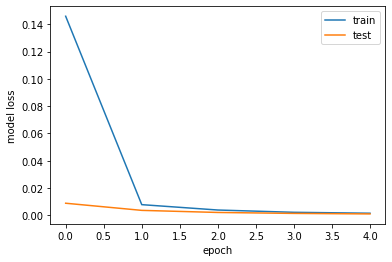

In [ ]:
with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()],
        )


history=model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)

tf_save_directory = "./tf_save_pretrained"
tokenizer.save_pretrained(tf_save_directory)
model.save_pretrained(tf_save_directory)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.savefig('train_history.png')
plt.show()

# AUT curve

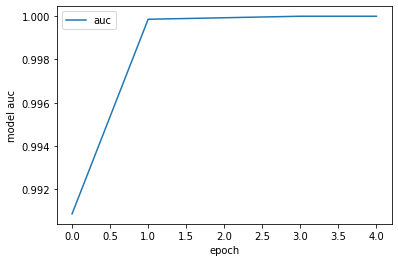

In [ ]:
plt.plot(history.history['auc'])
plt.ylabel('model auc')
plt.xlabel('epoch')
plt.legend(['auc'], loc='best')
plt.savefig('auc.png')
plt.show()

In [ ]:
tokens=tokenizer(test_texts, padding=True,truncation=True, return_tensors='tf')
logits=model.predict(dict(tokens), verbose=1).logits
prob=tf.nn.sigmoid(logits).numpy()
predictions=np.argmax(prob, axis=1)

141/141 [==============================] - 27s 163ms/step


In [ ]:
y_true = test_labels
y_pred = predictions
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
print('AUC value is' ,metrics.auc(fpr, tpr))

AUC value is 1.0


In [ ]:
print(classification_report(y_true, y_pred, target_names=['real_news', 'fake_news']))

              precision    recall  f1-score   support

   real_news       1.00      1.00      1.00      2106
   fake_news       1.00      1.00      1.00      2384

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490



# Alert!!!

With these results, I've been shocked. I know transformers are so powerfull but when you see around 100% accuracy you must be a little suspecios to find whats wrong!

After I manually checked to find what is the difference between real and fake news text. I found something so obvious.
here we go ...

when I decided to check the real news texts.

I realised this:

In [ ]:
for i in df[(df.category == 0)].sample(20).text.values:
  print(i[:50])

WASHINGTON (Reuters) - Washington, D.C.’s city cou
NAIROBI (Reuters) - Kenya s election board chairma
WASHINGTON (Reuters) - U.S. President Donald Trump
BEIRUT (Reuters) - The U.S.-backed Syrian Democrat
BEIRUT (Reuters) - Lebanon s army will deploy alon
BRUSSELS (Reuters) - U.S. President Donald Trump a
WASHINGTON (Reuters) - The shocking shooting death
 WASHINGTON (Reuters) - Donald Trump may have done
DUBAI (Reuters) - Gulf carriers Etihad Airways and
EDMONTON, Alberta (Reuters) - A Somali refugee who
PHILADELPHIA (Reuters) - U.S. President Donald Tru
RIYADH (Reuters) - President Barack Obama and Saud
WASHINGTON (Reuters) - Mexico’s economy minister o
THE HAGUE (Reuters) - The U.N. war crimes court th
(Reuters) - U.S. Republican presidential candidate
WASHINGTON (Reuters) - U.S. President Barack Obama
BERLIN (Reuters) - Germany s Social Democrats (SPD
MILAN (Reuters) - Former U.S. President Barack Oba
XIAMEN, China (Reuters) - Russian President Vladim
BEDMINSTER, N.J. (Reuters) - Pr

As you can see almost(or quite) all of them have "**(Reuters)**"; It is one of the first words of the text and after that, we have **"-"** (dash or hyphen).

In [ ]:
print('number of real news:', df[(df.category == 0)].shape[0])
print('number of real news without "(Reuters)":', df[df.text.str.contains('(Reuters)') & (df.category == 0)].shape[0])
print(21417 - 21378)

number of real news: 21417
number of real news without "(Reuters)": 21378
39


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


But you can't saw that when you checked fake news text.
There is no Reuters.

In [ ]:
for i in df[(df.category == 1)].sample(20).text.values:
  print(i[:50])

As our limp-wristed President flies around on taxp
Ever since the horrific act of senseless violence 
If Donald Trump has his way, the constitutional ri
Don t you just love the absolute boldness of the M
President Trump was right again! His campaign mana
21st Century Wire says There is one curious thing 
 Democrats are the party of KKK The problem is, yo
 (Photo: Patrick Henningsen 2016)News LineThe Whit
Trinity Lutheran Church in Columbia, Missouri has 
 By Vin ArmaniHillary Clinton continues to blame R
The father of a Virginia reporter who was shot to 
Political pundit Joe Scarborough has a Donald Trum
It s great to see one of the Justices questioning 
The press was not happy and took to Twitter to hav
For the longest time, Donald Trump has been advoca
BREAKING: #TimKaine rally only about 30 people sho
69 people were shot in gun-free Chicago over this 
San Francisco 49ers quarterback Colin Kaepernick a
Here s a question for the anti-Trump media: If Put
Here is the list of Republicans

So I suppose this dataset is not so good for this task. Maybe we should remove every character before the dash.

Lets check this out with test dataset.

In [ ]:
new_test_texts = list()
for t in test_texts:
  place = t.find('(Reuters) -')
  if place < 100:
    new_test_texts.append(t[place+12:].strip())
    continue
  new_test_texts.append(t)

In [ ]:
tokens=tokenizer(new_test_texts, padding=True,truncation=True, return_tensors='tf')
logits=model.predict(dict(tokens), verbose=1).logits
prob=tf.nn.sigmoid(logits).numpy()
predictions=np.argmax(prob, axis=1)

141/141 [==============================] - 9s 56ms/step


In [ ]:
y_true = test_labels
y_pred = predictions
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
print('AUC value is' ,metrics.auc(fpr, tpr))

AUC value is 0.9976258309591644


In [ ]:
print(classification_report(y_true, y_pred, target_names=['real_news', 'fake_news']))

              precision    recall  f1-score   support

   real_news       1.00      1.00      1.00      2106
   fake_news       1.00      1.00      1.00      2384

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490



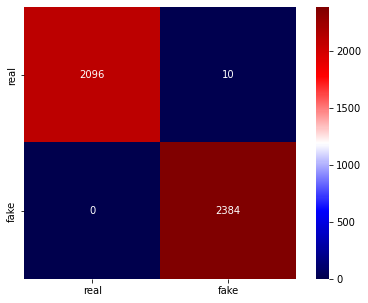

In [ ]:
confusion_matrix=tf.math.confusion_matrix(y_true, y_pred, num_classes=n_categories)

plt.figure(figsize=(7,5))
sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='seismic', square=True, xticklabels=['real','fake'], yticklabels=['real','fake']) 

In [ ]:
indices = np.where(y_true != y_pred)[0]

wrong_texts = list()
for i in indices:
  wrong_texts.append(new_test_texts[i])

In [ ]:
wrong_texts

['Israel s intelligence minister said U.S. President Donald Trump s speech against the 2015 international nuclear deal with Iran on Friday was  very significant  and could lead to war given threats that preceded it from Tehran. Israel s Channel 2 TV asked Intelligence Minister Israel Katz whether he saw a risk of war after Trump s speech.  Absolutely, yes. I think that the speech was very significant,  Katz responded.  Iran is the new North Korea. We see where things are goings.   Israeli minister says Trump speech may start war with Iran',
 "I am voluntarily providing this statement, submitting documents, and sitting for interviews in order to shed light on issues that have been raised about my role in the Trump for President Campaign and during the transition period. I am not a person who has sought the spotlight. First in my business and now in public service, I have worked on achieving goals, and have left it to others to work on media and public perception. Because there has been 

#save the model

In [ ]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/token.
        (Deprecated, will be removed in v0.3.0) To login with username and password instead, interrupt with Ctrl+C.
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
!git config --global credential.helper store

In [ ]:
!git lfs install

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.


In [ ]:
from huggingface_hub import Repository
repo = Repository(
    local_dir = 'mamad', 
    clone_from='erfan-sams/roberta-fake-news'
)

Cloning https://huggingface.co/erfan-sams/roberta-fake-news into local empty directory.


Download file tf_model.h5:   0%|          | 3.47k/476M [00:00<?, ?B/s]

Clean file tf_model.h5:   0%|          | 1.00k/476M [00:00<?, ?B/s]

In [ ]:
repo.push_to_hub(
   commit_message = "Our first big model!"
)

Upload file tf_model.h5:   0%|          | 3.34k/476M [00:00<?, ?B/s]

To https://huggingface.co/erfan-sams/roberta-fake-news
   c9b885a..67e3303  main -> main

   c9b885a..67e3303  main -> main



'https://huggingface.co/erfan-sams/roberta-fake-news/commit/67e330397d1e0cc92869f42caf6df9f9eb8a5ecc'